# Preproccessing

In [1]:
# preprocessed_file_name = 'preprocessed_NaN.mat'

In [2]:
preprocessed_file_name = 'preprocessed_data.mat'

In [3]:
import pyedflib
import mne
import numpy as np
from scipy.io import savemat
import matplotlib.pyplot as plt
import scipy.io
from scipy.interpolate import interp1d
from scipy.io import savemat, loadmat


# Load the EDF file
edf_path = '../data/201 N1.edf'
raw = mne.io.read_raw_edf(edf_path, preload=True)

# Convert to microvolts
raw._data *= 1e6  # Convert from volts to microvolts
print(f"After conversion to μV - Min: {raw._data.min():.2f}, Max: {raw._data.max():.2f}")

# Bandpass filter from 0.5 to 50 Hz
raw.filter(0.5, 50, fir_design='firwin')
print(f"After filtering - Min: {raw._data.min():.2f}, Max: {raw._data.max():.2f}")

# Downsample to 100 Hz
raw.resample(100)
print(f"After resampling - Min: {raw._data.min():.2f}, Max: {raw._data.max():.2f}")

# Print out the channel names in the raw EDF data
print("Channel names:", raw.ch_names)

# Create bipolar montage
bipolar_montage = mne.set_bipolar_reference(
    raw,
    anode=['F3-M2', 'C3-M2', 'F4-M1', 'C4-M1'],
    cathode=['C3-M2', 'O1-M2', 'C4-M1', 'O2-M1'],
    ch_name=['F3-C3', 'C3-O1', 'F4-C4', 'C4-O2']
)

# Pick only the bipolar channels
raw = bipolar_montage.pick_channels(['F3-C3', 'C3-O1', 'F4-C4', 'C4-O2'])
print(f"After bipolar montage - Min: {raw._data.min():.2f}, Max: {raw._data.max():.2f}")

# Segment into 30-second epochs
epochs = mne.make_fixed_length_epochs(raw, duration=30, preload=True)
print(f"After epoching - Min: {epochs._data.min():.2f}, Max: {epochs._data.max():.2f}")

Extracting EDF parameters from /Users/jackkrolik/Downloads/Code/eeg-sleepstage-classifier/data/201 N1.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 8952199  =      0.000 ... 44760.995 secs...


/var/folders/4f/sgn_zcm52nl7hs_clb0tdbph0000gn/T/ipykernel_65942/2832317485.py:13: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True)
/var/folders/4f/sgn_zcm52nl7hs_clb0tdbph0000gn/T/ipykernel_65942/2832317485.py:13: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_path, preload=True)


After conversion to μV - Min: -60257.68, Max: 999221.79
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 1321 samples (6.605 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    3.1s


After filtering - Min: -468588.63, Max: 468588.63
After resampling - Min: -464247.88, Max: 468712.50
Channel names: ['LOC', 'ROC', 'F3-M2', 'F4-M1', 'C3-M2', 'C4-M1', 'P3-M2', 'P4-M1', 'O1-M2', 'O2-M1', 'Chin', 'Chest', 'Abdomen', 'SAO2', 'Airflow', 'EKG', 'Snore', 'R-R', 'CPAP']
EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=4, n_times=4476100
    Range : 0 ... 4476099 =      0.000 ... 44760.990 secs
Ready.
Added the following bipolar channels:
F3-C3, C3-O1, F4-C4, C4-O2
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
After bipolar montage - Min: -7827.74, Max: 7724.69
Not setting metadata
1492 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 1492 events and 3000 original time points ...
0 bad epochs dropped
After epoching - Min: -7827.74, Max: 7724.69


Dropped 5 epochs: 203, 453, 454, 455, 1489
Total interpolated amplitude artifacts in kept epochs: 6999
Total interpolated flat signal artifacts in kept epochs: 0
Total amplitude artifacts in removed epochs: 6700
Total flat signal artifacts in removed epochs: 0
Number of epochs removed due to long artifacts: 5
After artifact handling - Min: -499.64, Max: 499.75
After scaling - Min: -702.63, Max: 702.23
Data saved successfully.


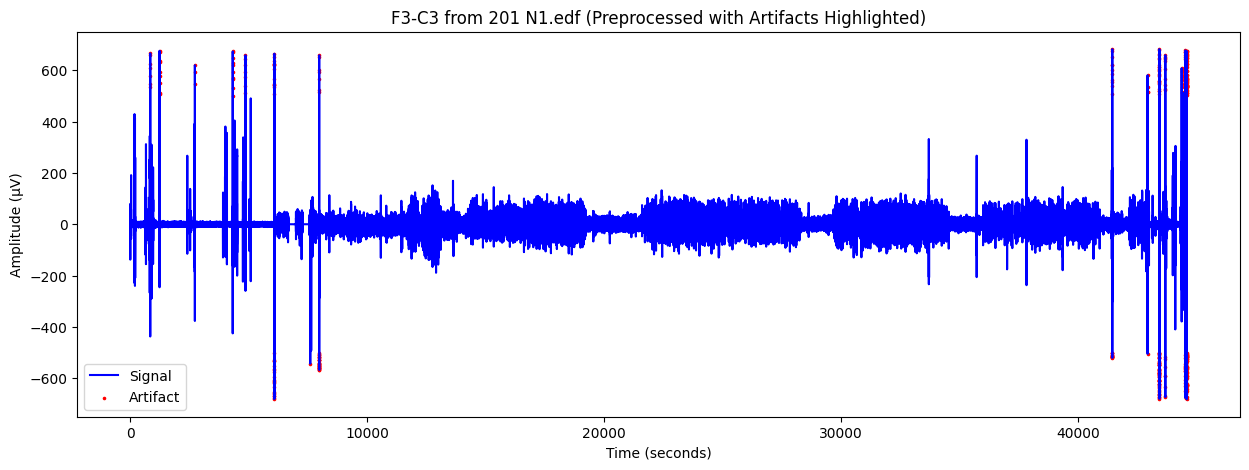

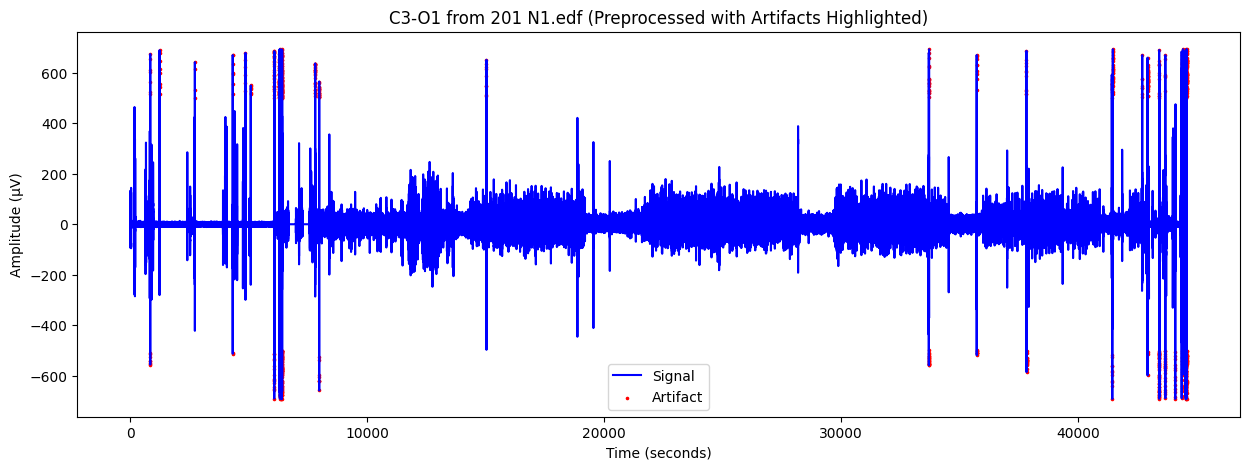

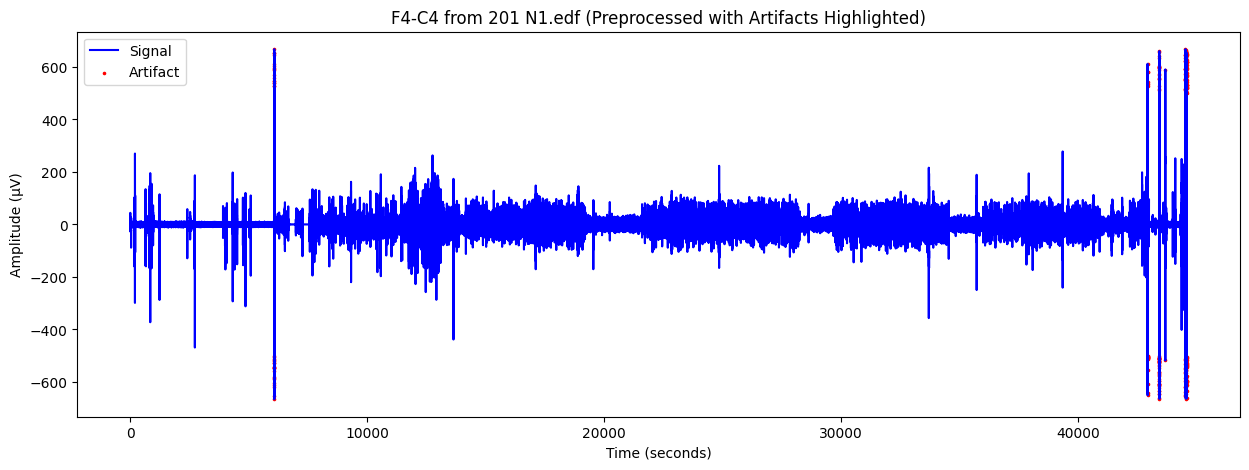

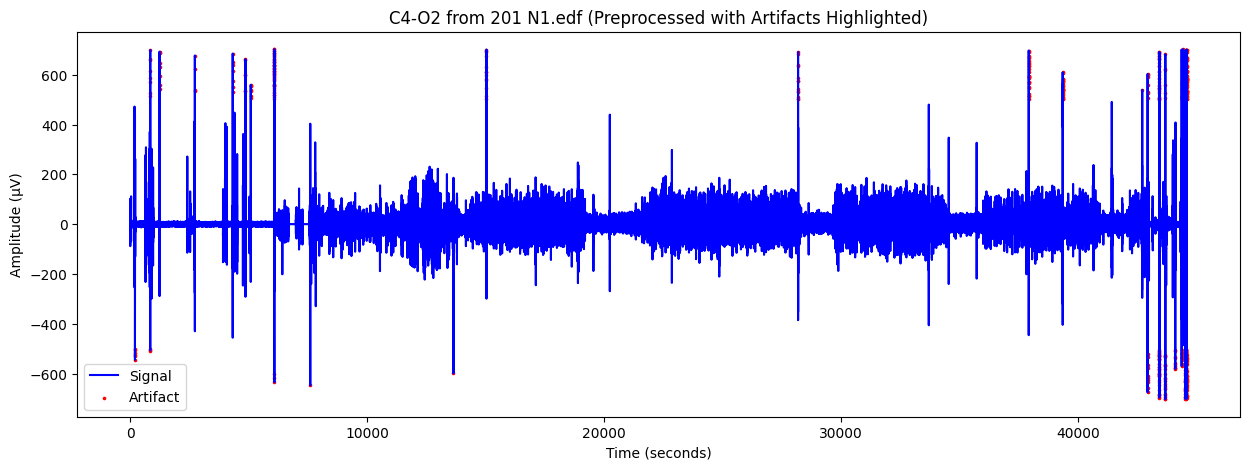

Final data range: -702.63 to 702.23 μV


In [4]:
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage
import torch

# Precompute shared value
sfreq = raw.info['sfreq']

# Optimized artifact detection function with shape correction
def detect_artifacts(data, threshold=500, flat_threshold=1e-6, flat_duration=5, sfreq=100):
    # Amplitude mask (same length as the data)
    amplitude_mask = np.abs(data) > threshold
    
    # Flat signal detection (diff reduces length by 1)
    diff = np.abs(np.diff(data))
    flat_mask = np.zeros_like(data, dtype=bool)  # Initialize with the same length as data
    flat_mask[:-1] = ndimage.uniform_filter1d(diff < flat_threshold, size=int(flat_duration * sfreq)) > 0.99
    
    return amplitude_mask, flat_mask

# Optimized artifact handling
def handle_artifacts(data, artifact_mask):
    data[artifact_mask] = 0  # You could also use np.nan depending on the requirements
    return data

# Optimized preprocessing function for sleep stages
def preprocess_sleep_stages(file_path, epochs_to_remove, keep_unscored=False):
    stage_mapping = {7: 4, 5: 3, 1: 2, 2: 1, 3: 0, 0: -1}

    with open(file_path, 'r') as file:
        lines = file.readlines()[2:]  # Skip the first two lines

    sleep_stages = np.array([int(line.split()[0]) for line in lines])

    # Efficiently find start and end of awake states (7)
    start_index = np.argmax(sleep_stages == 7)
    end_index = len(sleep_stages) - np.argmax(sleep_stages[::-1] == 7)

    # Ensure 50 awake states at start and end
    sleep_stages[max(0, start_index - 50):start_index] = 7
    sleep_stages[end_index:min(len(sleep_stages), end_index + 50)] = 7

    processed_stages = sleep_stages if keep_unscored else sleep_stages[start_index:end_index]

    # Renumber stages and remove unwanted epochs
    renumbered_stages = np.vectorize(stage_mapping.get)(processed_stages)
    np_stages = np.delete(renumbered_stages, list(epochs_to_remove), axis=0)

    return np_stages.reshape(1, -1)

# Initialize arrays to track artifacts
num_epochs = epochs._data.shape[0]
amplitude_artifact_counts = np.zeros(num_epochs)
flat_artifact_counts = np.zeros(num_epochs)
epochs_to_remove = []  # Change this to a list to preserve order

# Apply artifact detection and handling
for i in range(num_epochs):  # Loop through epochs
    for j in range(epochs._data.shape[1]):  # Loop through channels
        data_epoch = epochs._data[i, j, :]
        amplitude_mask, flat_mask = detect_artifacts(data_epoch, sfreq=sfreq)
        artifact_mask = amplitude_mask | flat_mask
        
        # Count the number of artifacts for each epoch
        amplitude_artifact_counts[i] += np.sum(amplitude_mask)
        flat_artifact_counts[i] += np.sum(flat_mask)
        
        # Remove epochs with long consecutive artifacts (e.g., 5 seconds)
        if (np.sum(amplitude_mask) >= 5 * sfreq) or (np.sum(flat_mask) >= 5 * sfreq):
            epochs_to_remove.append(i)
            break
        
        # Handle artifacts in one pass
        epochs._data[i, j, :] = handle_artifacts(data_epoch, artifact_mask)



# Separate the artifact counts for kept and removed epochs
kept_amplitude_counts = np.delete(amplitude_artifact_counts, list(epochs_to_remove))
kept_flat_counts = np.delete(flat_artifact_counts, list(epochs_to_remove))
# Separate the artifact counts for kept and removed epochs
removed_amplitude_counts = amplitude_artifact_counts[epochs_to_remove]
removed_flat_counts = flat_artifact_counts[epochs_to_remove]

# Remove epochs marked for removal
epochs.drop(epochs_to_remove)

# Print total artifact counts and epoch removal information
print(f"Total interpolated amplitude artifacts in kept epochs: {int(np.sum(kept_amplitude_counts))}")
print(f"Total interpolated flat signal artifacts in kept epochs: {int(np.sum(kept_flat_counts))}")
print(f"Total amplitude artifacts in removed epochs: {int(np.sum(removed_amplitude_counts))}")
print(f"Total flat signal artifacts in removed epochs: {int(np.sum(removed_flat_counts))}")
print(f"Number of epochs removed due to long artifacts: {len(epochs_to_remove)}")

# Print data range after artifact handling
print(f"After artifact handling - Min: {epochs._data.min():.2f}, Max: {epochs._data.max():.2f}")

# Your target medians and IQRs for each channel
iqr_target = torch.tensor([7.90, 11.37, 7.92, 11.56])
med_target = torch.tensor([0.0257, 0.0942, 0.02157, 0.1055])

# Efficiently rescale each channel
for i, ch in enumerate(raw.ch_names):
    data = epochs.get_data(picks=ch).reshape(-1)
    median = np.median(data)
    iqr = np.percentile(data, 75) - np.percentile(data, 25)
    
    # Scale the data to match target median and IQR
    scaled_data = (data - median) / iqr * iqr_target[i].item() + med_target[i].item()
    epochs._data[:, epochs.ch_names.index(ch), :] = scaled_data.reshape(epochs._data.shape[0], -1)

# Print data range after scaling
print(f"After scaling - Min: {epochs._data.min():.2f}, Max: {epochs._data.max():.2f}")

# Extract preprocessed data (without the need for transposition)
preprocessed_data = epochs.get_data()

file_path = '../data/Sleep Stages 201_N1.txt'  # Replace with the actual file path


# Save the preprocessed data
mat_dict = {
    'sig1': preprocessed_data[:, 0, :],  
    'sig2': preprocessed_data[:, 1, :],  
    'sig3': preprocessed_data[:, 2, :],  
    'sig4': preprocessed_data[:, 3, :],  
    'Fs': sfreq,
    'ch_names': raw.ch_names,
    'labels': preprocess_sleep_stages(file_path, epochs_to_remove, keep_unscored=True)
}

# Save as .mat file
preprocessed_file_name = 'preprocessed_data.mat'
try:
    scipy.io.savemat(preprocessed_file_name, mat_dict)
    print("Data saved successfully.")
except Exception as e:
    print(f"Error saving data: {e}")

# Plot function
def plot_channel(data, artifact_mask, channel_name, fs):
    time = np.arange(len(data)) / fs
    plt.figure(figsize=(15, 5))
    plt.plot(time, data, label="Signal", color='blue')
    artifact_indices = np.where(artifact_mask)[0]
    if artifact_indices.size > 0:
        plt.scatter(time[artifact_indices], data[artifact_indices], color='red', label="Artifact", marker='.', s=10)
    plt.title(f'{channel_name} from 201 N1.edf (Preprocessed with Artifacts Highlighted)')
    plt.xlabel('Time (seconds)')
    plt.ylabel('Amplitude (μV)')
    plt.legend()
    plt.show()

# Plot each channel and highlight artifacts
for i, ch_name in enumerate(raw.ch_names):
    channel_data = preprocessed_data[:, i, :].flatten()
    amplitude_mask, flat_mask = detect_artifacts(channel_data, sfreq=sfreq)
    plot_channel(channel_data, amplitude_mask | flat_mask, ch_name, sfreq)

# Check data quality
def check_data_quality(data):
    if np.isnan(data).any():
        print("Warning: NaN values detected in preprocessed data.")
    if np.isinf(data).any():
        print("Warning: Infinite values detected in preprocessed data.")
    print(f"Final data range: {data.min():.2f} to {data.max():.2f} μV")

check_data_quality(preprocessed_data)

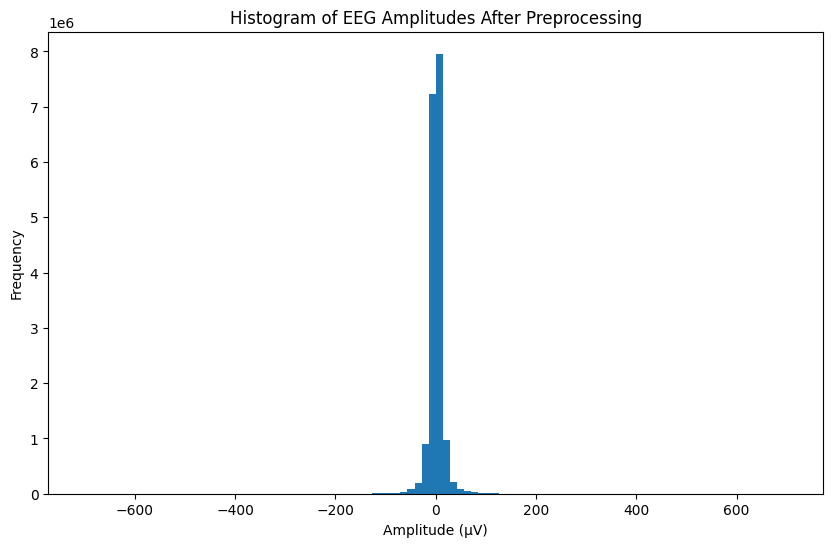

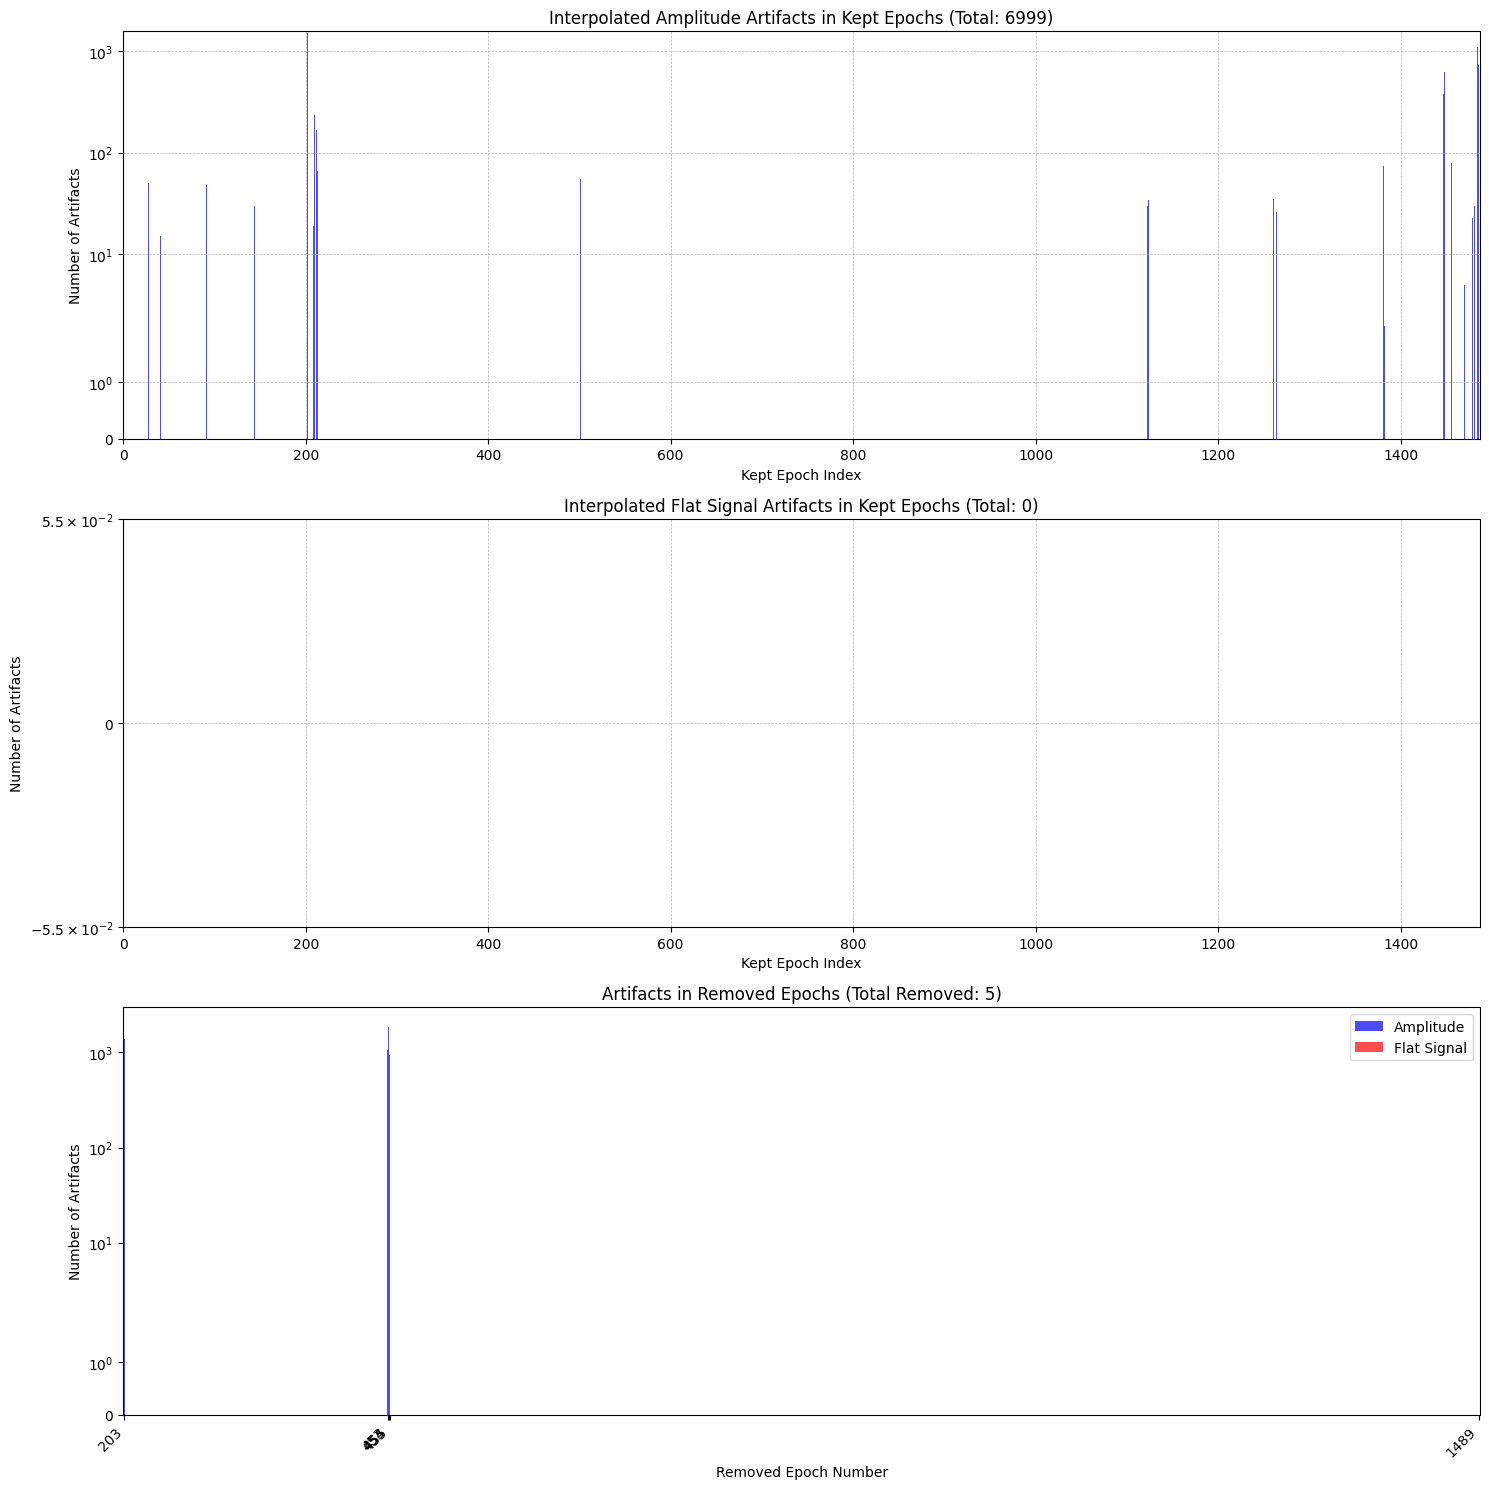

Number of sleep stages: 1487
Number of epochs: 1487


In [5]:
import numpy as np
import matplotlib.pyplot as plt

def plot_histogram(data, title='Histogram of EEG Amplitudes After Preprocessing', xlabel='Amplitude (μV)', ylabel='Frequency', bins=100, figsize=(10, 6)):
    """
    Function to plot a histogram for the given data.
    
    Parameters:
    - data: The data to plot the histogram for.
    - title: The title of the plot.
    - xlabel: Label for the x-axis.
    - ylabel: Label for the y-axis.
    - bins: Number of bins for the histogram.
    - figsize: Size of the figure.
    """
    plt.figure(figsize=figsize)
    plt.hist(data.flatten(), bins=bins)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()


def plot_artifact_counts(ax, title, counts, color, xlabel, ylabel, epoch_label, log_scale=True):
    """
    Plots the artifact counts for a specific set of epochs.
    
    Parameters:
    - ax: The axis object to plot on.
    - title: The title of the plot.
    - counts: The array of artifact counts to plot.
    - color: The color of the bars.
    - xlabel: The label for the x-axis.
    - ylabel: The label for the y-axis.
    - epoch_label: A string to describe the type of epoch (e.g., "Kept" or "Removed").
    - log_scale: Whether to apply a symlog scale to the y-axis.
    """
    ax.bar(np.arange(len(counts)), counts, color=color, alpha=0.7)
    ax.set_title(f'{title} (Total: {int(np.sum(counts))})')
    ax.set_xlabel(f'{epoch_label} Epoch Index')
    ax.set_ylabel(ylabel)
    ax.set_xlim(0, max(1, len(counts)))
    ax.grid(True, which='both', linestyle='--', linewidth=0.5)
    
    if log_scale:
        ax.set_yscale('symlog')



def select_ticks(epoch_numbers, max_ticks=10):
    if len(epoch_numbers) <= max_ticks:
        return epoch_numbers
    
    step = max(1, len(epoch_numbers) // max_ticks)
    return epoch_numbers[::step]

def plot_combined_artifacts(ax, amp_counts, flat_counts, epoch_numbers, xlabel, ylabel):
    ax.bar(epoch_numbers, amp_counts, color='blue', alpha=0.7, label='Amplitude')
    ax.bar(epoch_numbers, flat_counts, color='red', alpha=0.7, label='Flat Signal')
    
    num_removed_epochs = len(epoch_numbers)
    ax.set_title(f'Artifacts in Removed Epochs (Total Removed: {num_removed_epochs})')
    
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_yscale('symlog')
    ax.legend()
    
    # Use the select_ticks function to choose which ticks to display
    selected_ticks = select_ticks(epoch_numbers)
    ax.set_xticks(selected_ticks)
    ax.set_xticklabels(selected_ticks, rotation=45, ha='right')
    
    # Ensure all epoch numbers are included in the x-axis range
    ax.set_xlim(min(epoch_numbers) - 1, max(epoch_numbers) + 1)

def plot_removed_epochs_no_data(ax):
    """
    Displays a message when no epochs were removed due to artifacts.
    
    Parameters:
    - ax: The axis object to display the message on.
    """
    ax.text(0.5, 0.5, 'No epochs were removed', ha='center', va='center', fontsize=12)
    ax.set_title('Artifacts in Removed Epochs')
    ax.axis('off')

def plot_artifact_summary(kept_amplitude_counts, kept_flat_counts, removed_amplitude_counts, removed_flat_counts):
    """
    Creates subplots for artifact counts across kept and removed epochs.
    
    Parameters:
    - kept_amplitude_counts: Array of amplitude artifact counts for kept epochs.
    - kept_flat_counts: Array of flat signal artifact counts for kept epochs.
    - removed_amplitude_counts: Array of amplitude artifact counts for removed epochs.
    - removed_flat_counts: Array of flat signal artifact counts for removed epochs.
    """
    fig, ax = plt.subplots(3, 1, figsize=(15, 15))

    # Plot for kept epochs - Amplitude artifacts
    plot_artifact_counts(ax[0], 'Interpolated Amplitude Artifacts in Kept Epochs', kept_amplitude_counts, 
                         color='blue', xlabel='Kept Epoch Index', ylabel='Number of Artifacts', epoch_label='Kept')

    # Plot for kept epochs - Flat signal artifacts
    plot_artifact_counts(ax[1], 'Interpolated Flat Signal Artifacts in Kept Epochs', kept_flat_counts, 
                         color='red', xlabel='Kept Epoch Index', ylabel='Number of Artifacts', epoch_label='Kept')

    
    # In your main code, modify the loop as follows:
    if len(removed_amplitude_counts) > 0:
        plot_combined_artifacts(ax[2], removed_amplitude_counts, removed_flat_counts, 
                                epoch_numbers=epochs_to_remove,  # Use the actual epoch numbers
                                xlabel='Removed Epoch Number', 
                                ylabel='Number of Artifacts')
    else:
        plot_removed_epochs_no_data(ax[2])

    plt.tight_layout()
    plt.show()

plot_histogram(preprocessed_data, title='Histogram of EEG Amplitudes After Preprocessing')
# Call the plotting function with the relevant data
plot_artifact_summary(kept_amplitude_counts, kept_flat_counts, removed_amplitude_counts, removed_flat_counts)


# Print number of sleep stages and epochs
print(f"Number of sleep stages: {mat_dict['labels'].shape[1]}")
print(f"Number of epochs: {preprocessed_data.shape[0]}")

# TESTING

In [6]:
# Imports

import scipy.io as sio
import matplotlib.pyplot as plt
from sklearn.metrics import cohen_kappa_score, accuracy_score, confusion_matrix
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from tqdm import tqdm
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold
from scipy.signal import welch
from imblearn.over_sampling import SMOTE
from torch.optim.lr_scheduler import ReduceLROnPlateau
import optuna
import os
import logging
import json
import sys
import logging

# Get the current working directory
current_dir = os.getcwd()

# Get the parent directory
parent_dir = os.path.dirname(current_dir)

# Add parent directory to sys.path
sys.path.insert(0, parent_dir)

# Import
from sleepdetector_new import ImprovedSleepdetector



# Set up logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# Set random seed for reproducibility
def set_seed(seed=42):
    torch.manual_seed(seed)
    np.random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed()


def load_data(filepath, add_dim=False):
    try:
        # Load the data from the .mat file
        mat_file = sio.loadmat(filepath)
        
        # Stack the signals into x
        x = np.stack((mat_file['sig1'], mat_file['sig2'], mat_file['sig3'], mat_file['sig4']), axis=1)
        x = torch.from_numpy(x).float()  # Convert to PyTorch tensor
        
        # Load the labels
        y = torch.from_numpy(mat_file['labels'].flatten()).long()
        
        # Remove epochs where y is -1 (if any)
        valid_indices = y != -1
        x = x[valid_indices]
        y = y[valid_indices]
        
        # x is already in shape [number of epochs, 4, 3000], so no need to permute
        
        if add_dim:
            x = x.unsqueeze(1)  # Add an extra dimension if required
        
        return x, y

    except Exception as e:
        logging.error(f"Error loading data: {e}")
        raise


def extract_spectral_features(x):
    features = []
    for channel in x:
        f, psd = welch(channel.squeeze().numpy(), fs=100, nperseg=1000)
        delta = np.sum(psd[(f >= 0.5) & (f <= 4)])
        theta = np.sum(psd[(f > 4) & (f <= 8)])
        alpha = np.sum(psd[(f > 8) & (f <= 13)])
        beta = np.sum(psd[(f > 13) & (f <= 30)])
        features.extend([delta, theta, alpha, beta])
    return np.array(features)


def prepare_data(x, y, test_size=0.2, split=True):
    """
    Prepare data for training or testing.
    
    :param x: Input data tensor
    :param y: Labels tensor
    :param test_size: Proportion of the dataset to include in the test split
    :param split: If True, split the data into train and test sets. If False, process all data without splitting.
    :return: Processed data tensors
    """
    if split:
        X_train, X_test, y_train, y_test = train_test_split(x.numpy(), y.numpy(), test_size=test_size, stratify=y, random_state=42)
        
        X_train_spectral = np.array([extract_spectral_features(torch.from_numpy(x)) for x in X_train])
        X_test_spectral = np.array([extract_spectral_features(torch.from_numpy(x)) for x in X_test])
        
        X_train_combined = np.concatenate([X_train.reshape(X_train.shape[0], -1), X_train_spectral], axis=1)
        X_test_combined = np.concatenate([X_test.reshape(X_test.shape[0], -1), X_test_spectral], axis=1)
        
        smote = SMOTE(random_state=42)
        X_train_resampled, y_train_resampled = smote.fit_resample(X_train_combined, y_train)
        
        original_shape = list(X_train.shape)
        original_shape[0] = X_train_resampled.shape[0]
        spectral_shape = (X_train_resampled.shape[0], X_train_spectral.shape[1])
        
        X_train_final = X_train_resampled[:, :-X_train_spectral.shape[1]].reshape(original_shape)
        X_train_spectral_final = X_train_resampled[:, -X_train_spectral.shape[1]:].reshape(spectral_shape)
        
        return (torch.from_numpy(X_train_final).float(),
                torch.from_numpy(X_train_spectral_final).float(),
                torch.from_numpy(y_train_resampled).long(),
                torch.from_numpy(X_test).float(),
                torch.from_numpy(X_test_spectral).float(),
                torch.from_numpy(y_test).long())
    else:
        X_spectral = np.array([extract_spectral_features(x_i) for x_i in x])
        
        return (x.float(),
                torch.from_numpy(X_spectral).float(),
                y.long())




# Model definition
class EnsembleModel(nn.Module):
    def __init__(self, model_params, n_models=3):
        super().__init__()
        self.models = nn.ModuleList([ImprovedSleepdetector(**model_params) for _ in range(n_models)])
    
    def forward(self, x, spectral_features):
        outputs = [model(x.clone(), spectral_features.clone()) for model in self.models]
        return torch.mean(torch.stack(outputs), dim=0)

# Training and evaluation functions
def train_model(model, train_loader, val_data, optimizer, scheduler, criterion, device, epochs=100):
    best_accuracy = 0
    best_model_state = None
    
    for epoch in tqdm(range(epochs), desc="Training Progress"):
        model.train()
        for batch_x, batch_x_spectral, batch_y in train_loader:
            batch_x, batch_x_spectral, batch_y = batch_x.to(device), batch_x_spectral.to(device), batch_y.to(device)
            optimizer.zero_grad()
            outputs = model(batch_x, batch_x_spectral)
            loss = criterion(outputs, batch_y)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
        
        accuracy = evaluate_model(model, val_data, device)
        
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_model_state = model.state_dict()
        
        scheduler.step(accuracy)
    
    return best_model_state, best_accuracy


def evaluate_model(model, data, device):
    model.eval()
    try:
        X, X_spectral, y = data
        logging.info(f"Data shapes - X: {X.shape}, X_spectral: {X_spectral.shape}, y: {y.shape}")
        
        with torch.no_grad():
            outputs = model(X.to(device), X_spectral.to(device))
            logging.info(f"Model output shape: {outputs.shape}")
            
            _, predicted = torch.max(outputs, 1)
            logging.info(f"Predicted shape: {predicted.shape}")
            
            accuracy = accuracy_score(y.cpu().numpy(), predicted.cpu().numpy())
            kappa = cohen_kappa_score(y.cpu().numpy(), predicted.cpu().numpy())
            
        return accuracy, kappa, predicted.cpu().numpy()
    except Exception as e:
        logging.error(f"Error in evaluate_model: {e}")
        raise





# Hyperparameter optimization
def objective(trial, X_train, X_train_spectral, y_train, X_test, X_test_spectral, y_test, device):
    model_params = {
        'n_filters': trial.suggest_categorical('n_filters', [[32, 64, 128], [64, 128, 256]]),
        'lstm_hidden': trial.suggest_int('lstm_hidden', 64, 512),
        'lstm_layers': trial.suggest_int('lstm_layers', 1, 3),
        'dropout': trial.suggest_float('dropout', 0.1, 0.5)
    }
    
    train_params = {
        'lr': trial.suggest_float('lr', 1e-5, 1e-2, log=True),
        'batch_size': trial.suggest_categorical('batch_size', [16, 32, 64, 128])
    }
    
    model = ImprovedSleepdetector(**model_params).to(device)
    optimizer = optim.Adam(model.parameters(), lr=train_params['lr'])
    train_loader = DataLoader(TensorDataset(X_train, X_train_spectral, y_train), batch_size=train_params['batch_size'], shuffle=True)
    
    _, accuracy = train_model(model, train_loader, (X_test, X_test_spectral, y_test), optimizer, ReduceLROnPlateau(optimizer), nn.CrossEntropyLoss(), device, epochs=10)
    
    return accuracy

# Cross-validation
def cross_validate(X, X_spectral, y, model_params, train_params, n_splits=5):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    scores = []

    for fold, (train_idx, val_idx) in enumerate(kf.split(X)):
        X_train_fold, X_val_fold = X[train_idx], X[val_idx]
        X_spectral_train_fold, X_spectral_val_fold = X_spectral[train_idx], X_spectral[val_idx]
        y_train_fold, y_val_fold = y[train_idx], y[val_idx]

        model = ImprovedSleepdetector(**model_params).to(device)
        optimizer = optim.Adam(model.parameters(), lr=train_params['lr'])
        train_loader = DataLoader(TensorDataset(X_train_fold, X_spectral_train_fold, y_train_fold), batch_size=train_params['batch_size'], shuffle=True)
        
        _, accuracy = train_model(model, train_loader, (X_val_fold, X_spectral_val_fold, y_val_fold), optimizer, ReduceLROnPlateau(optimizer), nn.CrossEntropyLoss(), device, epochs=50)
        scores.append(accuracy)
        
        logging.info(f"Fold {fold + 1} Accuracy: {accuracy:.4f}")
    
    logging.info(f"Average Accuracy: {np.mean(scores):.4f} (+/- {np.std(scores):.4f})")
    return scores

# Confusion matrix plotting
def plot_confusion_matrix(y_true, y_pred, normalize=False, title=None, cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Class names in the correct order (0 to 4)
    class_names = ['N3', 'N2', 'N1', 'REM', 'Awake']

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='.2f' if normalize else 'd',
                cmap=cmap, square=True, xticklabels=class_names, yticklabels=class_names)
    
    ax.set_ylabel('True label')
    ax.set_xlabel('Predicted label')
    ax.set_title(title)
    
    plt.tight_layout()
    return fig



/opt/homebrew/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
# Usage
x, y = load_data(preprocessed_file_name)
X, X_spectral, y = prepare_data(x, y, split=False)
print(f"X shape: {x.shape}, Y shape: {y.shape}")

X shape: torch.Size([1066, 4, 3000]), Y shape: torch.Size([1066])


Total Length of time in hours: 8.883333333333333


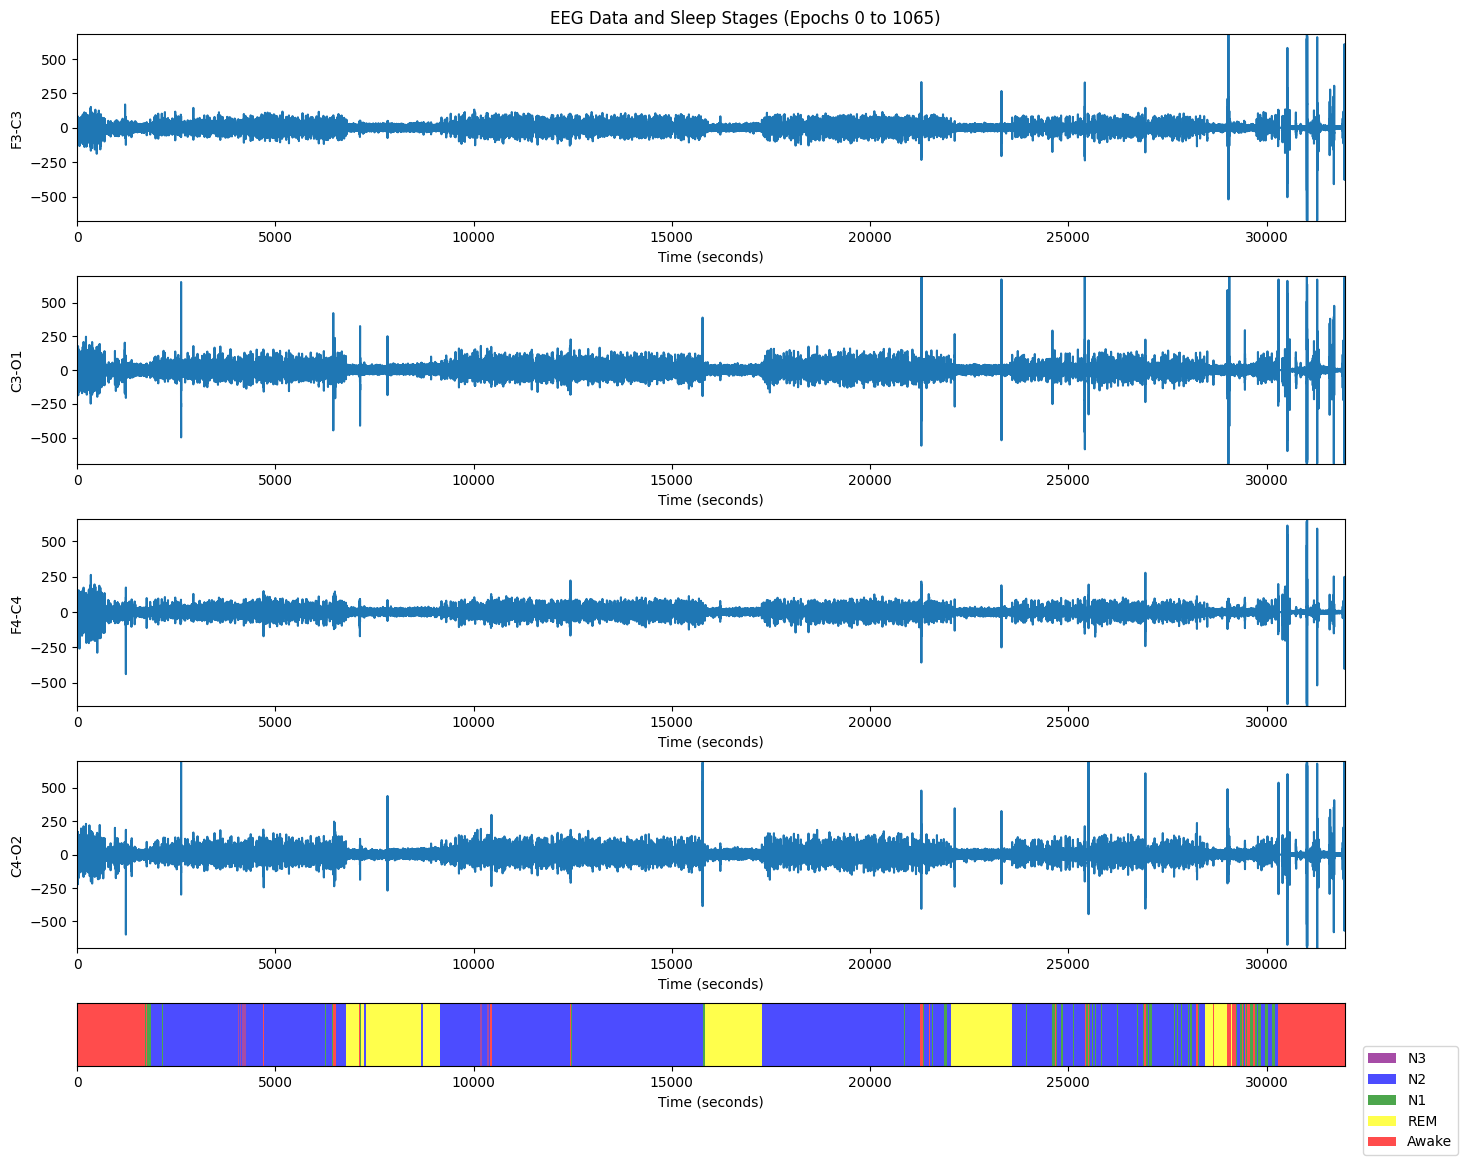

In [8]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import scipy.io
from matplotlib.colors import ListedColormap

def plot_eeg_and_sleep_stages(x, y, fs, ch_names, start_epoch=0, num_epochs=None):
    """
    Plot EEG data and corresponding sleep stages.
    
    :param x: EEG data tensor of shape (epochs, channels, time)
    :param y: Sleep stage labels tensor of shape (epochs,)
    :param fs: Sampling frequency (Hz)
    :param ch_names: List of EEG channel names
    :param start_epoch: Starting epoch to plot (default 0)
    :param num_epochs: Number of epochs to plot (default is all epochs)
    """
    if num_epochs is None:
        num_epochs = x.shape[0]
    
    start_epoch = max(0, min(start_epoch, x.shape[0] - num_epochs))
    
    plot_x = x[start_epoch:start_epoch+num_epochs].numpy()
    plot_y = y[start_epoch:start_epoch+num_epochs].numpy()
    
    num_samples_per_epoch = plot_x.shape[2]
    total_samples = num_epochs * num_samples_per_epoch
    time_vector = np.arange(total_samples) / fs
    
    # fig, axs = plt.subplots(5, 1, figsize=(15, 12), sharex=True, gridspec_kw={'height_ratios': [3, 3, 3, 3, 1]})
    fig, axs = plt.subplots(5, 1, figsize=(15, 12), sharex=False, gridspec_kw={'height_ratios': [3, 3, 3, 3, 1]})
    fig.suptitle(f'EEG Data and Sleep Stages (Epochs {start_epoch} to {start_epoch+num_epochs-1})')
    
    for i in range(4):
        flattened_data = plot_x[:, i, :].flatten()
        axs[i].plot(time_vector, flattened_data)
        axs[i].set_ylabel(ch_names[i])
        axs[i].set_xlim(0, total_samples / fs)
        axs[i].set_ylim(flattened_data.min(), flattened_data.max())
    
    stage_colors = ['purple', 'blue', 'green', 'yellow', 'red']  # Colors for N3, N2, N1, REM, Awake
    cmap = ListedColormap(stage_colors)
    
    epoch_duration = num_samples_per_epoch / fs
    for i, stage in enumerate(plot_y):
        start = i * epoch_duration
        end = (i + 1) * epoch_duration
        axs[4].axvspan(start, end, facecolor=stage_colors[int(stage)], alpha=0.7)
    
    axs[4].set_yticks([])
    # axs[4].set_xlabel('Time (seconds)')   
    axs[4].set_xlim(0, total_samples / fs)

    print("Total Length of time in hours:", total_samples / fs / 3600)

    for i in range(5):  # Now including the sleep stage plot
        axs[i].set_xlabel('Time (seconds)')

    # Create legend elements
    legend_elements = [plt.Rectangle((0,0),1,1, facecolor=stage_colors[i], alpha=0.7) 
                       for i in range(5)]
    
    # Add legend to the right side under the graph
    fig.legend(legend_elements, ['N3', 'N2', 'N1', 'REM', 'Awake'], 
               loc='lower right', bbox_to_anchor=(0.98, 0.02), ncol=1)
    
    plt.tight_layout()
    # Adjust the layout to make room for the legend
    plt.subplots_adjust(bottom=0.1, right=.9)
    return fig

# Usage remains the same
fs = scipy.io.loadmat(preprocessed_file_name)['Fs'].flatten()[0]
ch_names = scipy.io.loadmat(preprocessed_file_name)['ch_names'].flatten().tolist()

# Plot all epochs
plot_eeg_and_sleep_stages(x, y, fs, ch_names, start_epoch=0, num_epochs=None)
plt.show()

2024-09-27 22:17:21,628 - INFO - Loaded best model parameters: {'n_filters': [64, 128, 256], 'lstm_hidden': 270, 'lstm_layers': 1, 'dropout': 0.1724846458910379}
/var/folders/4f/sgn_zcm52nl7hs_clb0tdbph0000gn/T/ipykernel_65942/305631991.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have fu

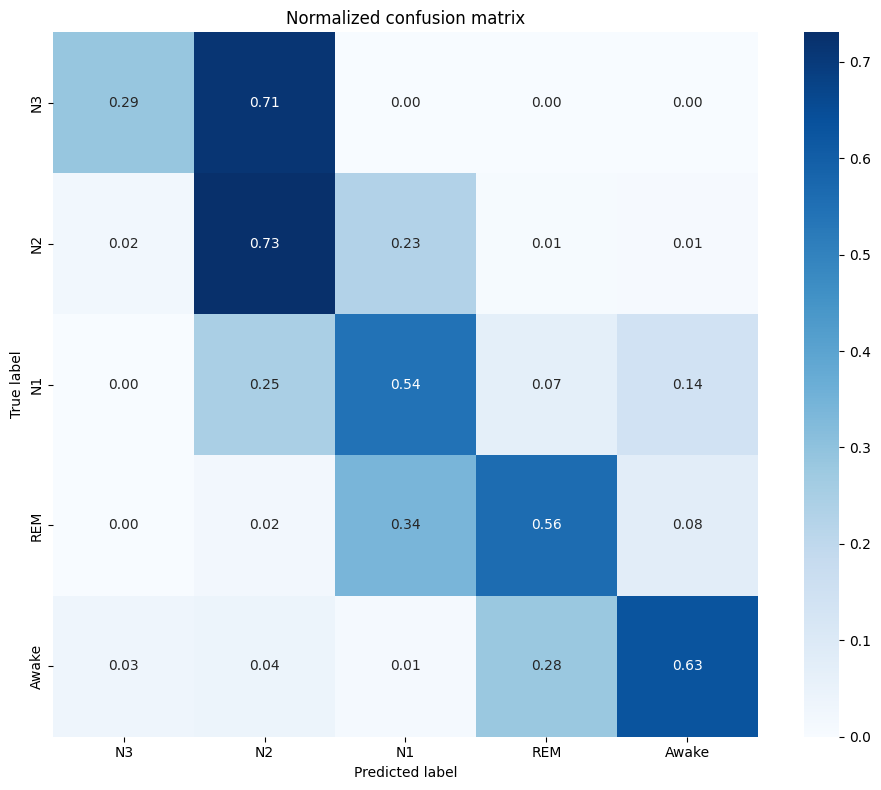

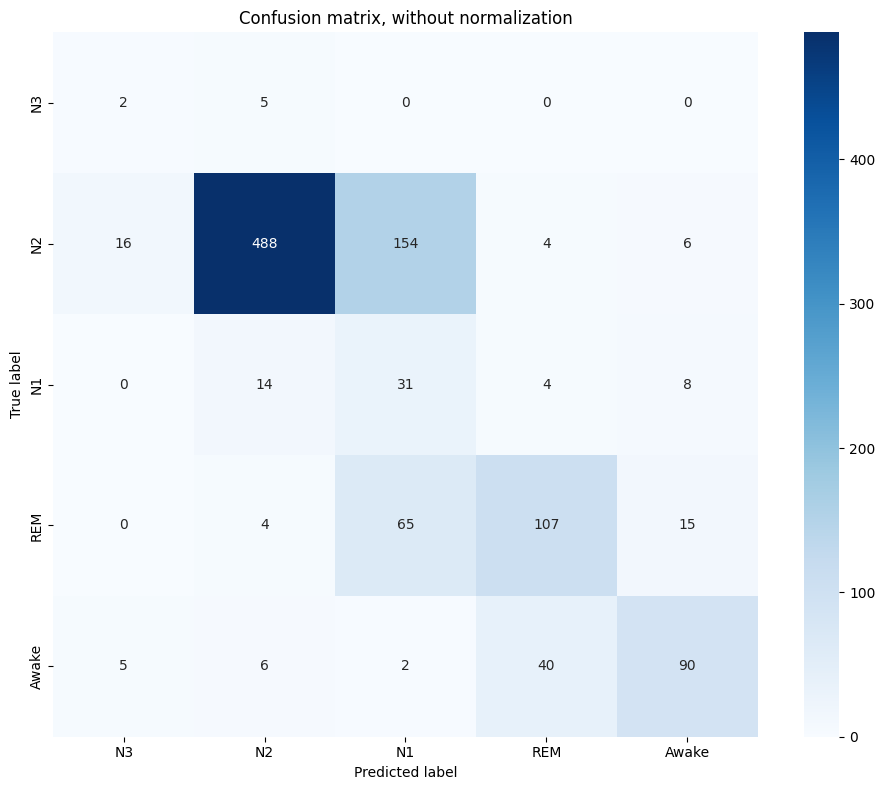

In [9]:
try:
    # Load the best parameters from JSON file
    with open('../models/best_params_ensemble.json', 'r') as f:
        params = json.load(f)
    
    best_model_params = params['best_model_params']
    logging.info(f"Loaded best model parameters: {best_model_params}")

    # Load the saved model
    model_state = torch.load("../models/best_ensemble_model.pth", map_location=device)
    
    # Recreate the model architecture using the loaded parameters
    model = EnsembleModel(best_model_params, n_models=3).to(device)
    
    # Load the state dict
    model.load_state_dict(model_state)
    logging.info("Model loaded successfully")

    # Evaluate the model
    logging.info("Starting model evaluation")
    accuracy, kappa, predictions = evaluate_model(model, (X, X_spectral, y), device)
    
    logging.info(f"Test Accuracy: {accuracy:.4f}")
    logging.info(f"Cohen's Kappa: {kappa:.4f}")

    # Plot and save confusion matrices
    fig_norm = plot_confusion_matrix(y.numpy(), predictions, normalize=True)
    fig_norm.savefig('../images/confusion_matrix_normalized.png')
    logging.info("Normalized confusion matrix saved to 'images' folder as 'confusion_matrix_normalized.png'") 
    

    fig_non_norm = plot_confusion_matrix(y.numpy(), predictions, normalize=False)
    fig_non_norm.savefig('../images/confusion_matrix_non_normalized.png')
    logging.info("Non-normalized confusion matrix saved to 'images' folder as 'confusion_matrix_non_normalized.png'")

except Exception as e:
    logging.error(f"An error occurred: {e}")
    logging.error(f"Error type: {type(e)}")
    logging.error(f"Error args: {e.args}")
    # Optionally, print the full traceback
    import traceback
    logging.error(f"Traceback: {traceback.format_exc()}")



In [10]:
# import numpy as np
# import matplotlib.pyplot as plt
# from sklearn.model_selection import train_test_split

# def introduce_artifacts(data, labels, artifact_ratio, max_consecutive_artifacts):
#     """
#     Introduce artifacts (zeros) into the data.
    
#     :param data: EEG data of shape (epochs, channels, time)
#     :param labels: Corresponding labels
#     :param artifact_ratio: Ratio of epochs to introduce artifacts
#     :param max_consecutive_artifacts: Maximum number of consecutive artifacts
#     :return: Data with artifacts, modified labels
#     """
#     num_epochs, num_channels, time_steps = data.shape
#     num_artifacts = int(num_epochs * artifact_ratio)
    
#     artifact_indices = np.random.choice(num_epochs, num_artifacts, replace=False)
    
#     for idx in artifact_indices:
#         consecutive_artifacts = np.random.randint(1, max_consecutive_artifacts + 1)
#         end_idx = min(idx + consecutive_artifacts, num_epochs)
#         data[idx:end_idx] = 0
#         labels[idx:end_idx] = -1  # Mark as artifact
    
#     return data, labels

# def test_artifact_impact(model, X, X_spectral, y, device, max_ratio=0.5, steps=10, test_size=0.2):
#     """
#     Test the impact of artifacts on model performance.
    
#     :param model: Trained model
#     :param X: EEG data
#     :param X_spectral: Spectral features
#     :param y: Labels
#     :param device: Computation device (CPU/GPU)
#     :param max_ratio: Maximum ratio of artifacts to introduce
#     :param steps: Number of steps to test
#     :param test_size: Ratio of data to use for testing
#     :return: Lists of artifact ratios, accuracies, and kappas
#     """
#     X_train, X_test, X_spectral_train, X_spectral_test, y_train, y_test = train_test_split(
#         X, X_spectral, y, test_size=test_size, stratify=y, random_state=42
#     )
    
#     artifact_ratios = np.linspace(0, max_ratio, steps)
#     accuracies = []
#     kappas = []
    
#     for ratio in artifact_ratios:
#         X_test_artifact, y_test_artifact = introduce_artifacts(
#             X_test.clone(), y_test.clone(), ratio, max_consecutive_artifacts=5
#         )
        
#         # Remove epochs marked as artifacts
#         valid_indices = y_test_artifact != -1
#         X_test_valid = X_test_artifact[valid_indices]
#         X_spectral_test_valid = X_spectral_test[valid_indices]
#         y_test_valid = y_test_artifact[valid_indices]
        
#         accuracy, kappa, _ = evaluate_model(model, (X_test_valid, X_spectral_test_valid, y_test_valid), device)
#         accuracies.append(accuracy)
#         kappas.append(kappa)
    
#     return artifact_ratios, accuracies, kappas

# def plot_artifact_impact(artifact_ratios, accuracies, kappas):
#     """
#     Plot the impact of artifacts on model performance.
    
#     :param artifact_ratios: List of artifact ratios
#     :param accuracies: List of accuracies
#     :param kappas: List of kappa scores
#     """
#     plt.figure(figsize=(10, 6))
#     plt.plot(artifact_ratios, accuracies, label='Accuracy', marker='o')
#     plt.plot(artifact_ratios, kappas, label='Cohen\'s Kappa', marker='s')
#     plt.xlabel('Artifact Ratio')
#     plt.ylabel('Score')
#     plt.title('Impact of Artifacts on Model Performance')
#     plt.legend()
#     plt.grid(True)
#     plt.savefig('../images/artifact_impact.png')
#     plt.show()

# # Usage
# artifact_ratios, accuracies, kappas = test_artifact_impact(model, X, X_spectral, y, device)
# plot_artifact_impact(artifact_ratios, accuracies, kappas)

# # Print the results
# for ratio, acc, kappa in zip(artifact_ratios, accuracies, kappas):
#     print(f"Artifact Ratio: {ratio:.2f}, Accuracy: {acc:.4f}, Kappa: {kappa:.4f}")

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, cohen_kappa_score
import torch

def introduce_artifacts(data, artifact_ratio, max_consecutive_artifacts):
    """
    Introduce artifacts (zeros) into the data without changing labels.
    
    :param data: EEG data of shape (epochs, channels, time)
    :param artifact_ratio: Ratio of epochs to introduce artifacts
    :param max_consecutive_artifacts: Maximum number of consecutive artifacts
    :return: Data with artifacts
    """
    num_epochs, num_channels, time_steps = data.shape
    num_artifacts = int(num_epochs * artifact_ratio)
    
    artifact_indices = np.random.choice(num_epochs, num_artifacts, replace=False)
    
    data_with_artifacts = data.clone()
    
    for idx in artifact_indices:
        consecutive_artifacts = np.random.randint(1, max_consecutive_artifacts + 1)
        end_idx = min(idx + consecutive_artifacts, num_epochs)
        data_with_artifacts[idx:end_idx] = 0
    
    return data_with_artifacts

def evaluate_model_with_artifacts(model, X, X_spectral, y, device):
    """
    Evaluate the model on data with artifacts.
    
    :param model: Trained model
    :param X: EEG data
    :param X_spectral: Spectral features
    :param y: Labels
    :param device: Computation device (CPU/GPU)
    :return: Accuracy and Cohen's Kappa
    """
    model.eval()
    with torch.no_grad():
        outputs = model(X.to(device), X_spectral.to(device))
        _, predicted = torch.max(outputs, 1)
        
        y_true = y.cpu().numpy()
        y_pred = predicted.cpu().numpy()
        
        # Calculate metrics
        acc = accuracy_score(y_true, y_pred)
        kappa = cohen_kappa_score(y_true, y_pred)
        
    return acc, kappa

def test_artifact_impact(model, X, X_spectral, y, device, max_ratio=0.5, steps=10, max_consecutive_range=(1, 10)):
    """
    Test the impact of artifacts on model performance.
    
    :param model: Trained model
    :param X: EEG data
    :param X_spectral: Spectral features
    :param y: Labels
    :param device: Computation device (CPU/GPU)
    :param max_ratio: Maximum ratio of artifacts to introduce
    :param steps: Number of steps to test for artifact ratio
    :param max_consecutive_range: Range of maximum consecutive artifacts to test
    :return: 2D lists of artifact ratios, max consecutive artifacts, accuracies, and kappas
    """
    artifact_ratios = np.linspace(0, max_ratio, steps)
    max_consecutive_artifacts = range(max_consecutive_range[0], max_consecutive_range[1] + 1)
    
    results = []
    
    for max_consec in max_consecutive_artifacts:
        accuracies = []
        kappas = []
        for ratio in artifact_ratios:
            X_artifact = introduce_artifacts(X, ratio, max_consec)
            
            # Recalculate spectral features for data with artifacts
            X_spectral_artifact = torch.tensor(np.array([extract_spectral_features(x) for x in X_artifact]))
            
            acc, kappa = evaluate_model_with_artifacts(model, X_artifact, X_spectral_artifact, y, device)
            accuracies.append(acc)
            kappas.append(kappa)
        
        results.append((max_consec, artifact_ratios.tolist(), accuracies, kappas))
    
    return results

def plot_artifact_impact(results):
    """
    Plot the impact of artifacts on model performance.
    
    :param results: List of tuples (max_consec, artifact_ratios, accuracies, kappas)
    """
    plt.figure(figsize=(15, 10))
    
    for max_consec, artifact_ratios, accuracies, kappas in results:
        plt.plot(artifact_ratios, accuracies, label=f'Accuracy (Max Consec: {max_consec})', marker='o')
        plt.plot(artifact_ratios, kappas, label=f'Kappa (Max Consec: {max_consec})', marker='s', linestyle='--')
    
    plt.xlabel('Artifact Ratio')
    plt.ylabel('Score')
    plt.title('Impact of Artifacts on Model Performance')
    plt.legend()
    plt.grid(True)
    plt.savefig('../images/artifact_impact_with_max_consec.png')
    plt.show()

# Usage
results = test_artifact_impact(model, X, X_spectral, y, device, max_ratio=0.3, steps=10, max_consecutive_range=(3, 10))
plot_artifact_impact(results)

# Print the results
for max_consec, artifact_ratios, accuracies, kappas in results:
    print(f"\nMax Consecutive Artifacts: {max_consec}")
    for ratio, acc, kappa in zip(artifact_ratios, accuracies, kappas):
        print(f"  Artifact Ratio: {ratio:.2f}, Accuracy: {acc:.4f}, Kappa: {kappa:.4f}")

KeyboardInterrupt: 

In [12]:
# import numpy as np
# import matplotlib.pyplot as plt
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import balanced_accuracy_score, cohen_kappa_score

# def introduce_artifacts(data, labels, artifact_ratio, max_consecutive_artifacts):
#     """
#     Introduce artifacts (zeros) into the data without removing epochs.
    
#     :param data: EEG data of shape (epochs, channels, time)
#     :param labels: Corresponding labels
#     :param artifact_ratio: Ratio of epochs to introduce artifacts
#     :param max_consecutive_artifacts: Maximum number of consecutive artifacts
#     :return: Data with artifacts, modified labels
#     """
#     num_epochs, num_channels, time_steps = data.shape
#     num_artifacts = int(num_epochs * artifact_ratio)
    
#     artifact_indices = np.random.choice(num_epochs, num_artifacts, replace=False)
    
#     data_with_artifacts = data.clone()
#     labels_with_artifacts = labels.clone()
    
#     for idx in artifact_indices:
#         consecutive_artifacts = np.random.randint(1, max_consecutive_artifacts + 1)
#         end_idx = min(idx + consecutive_artifacts, num_epochs)
#         data_with_artifacts[idx:end_idx] = 0
#         labels_with_artifacts[idx:end_idx] = -1  # Mark as artifact, but don't remove
    
#     return data_with_artifacts, labels_with_artifacts

# def evaluate_model_with_artifacts(model, X, X_spectral, y, device):
#     """
#     Evaluate the model, treating artifacts as a separate class.
    
#     :param model: Trained model
#     :param X: EEG data
#     :param X_spectral: Spectral features
#     :param y: Labels
#     :param device: Computation device (CPU/GPU)
#     :return: Balanced accuracy and Cohen's Kappa
#     """
#     model.eval()
#     with torch.no_grad():
#         outputs = model(X.to(device), X_spectral.to(device))
#         _, predicted = torch.max(outputs, 1)
        
#         # Treat artifacts (-1) as a separate class
#         y_true = y.cpu().numpy()
#         y_pred = predicted.cpu().numpy()
        
#         # Calculate metrics
#         balanced_acc = balanced_accuracy_score(y_true, y_pred)
#         kappa = cohen_kappa_score(y_true, y_pred)
        
#     return balanced_acc, kappa

# def test_artifact_impact(model, X, X_spectral, y, device, max_ratio=0.5, steps=10, test_size=0.2):
#     """
#     Test the impact of artifacts on model performance.
    
#     :param model: Trained model
#     :param X: EEG data
#     :param X_spectral: Spectral features
#     :param y: Labels
#     :param device: Computation device (CPU/GPU)
#     :param max_ratio: Maximum ratio of artifacts to introduce
#     :param steps: Number of steps to test
#     :param test_size: Ratio of data to use for testing
#     :return: Lists of artifact ratios, balanced accuracies, and kappas
#     """
#     X_train, X_test, X_spectral_train, X_spectral_test, y_train, y_test = train_test_split(
#         X, X_spectral, y, test_size=test_size, stratify=y, random_state=42
#     )
    
#     artifact_ratios = np.linspace(0, max_ratio, steps)
#     balanced_accuracies = []
#     kappas = []
    
#     for ratio in artifact_ratios:
#         X_test_artifact, y_test_artifact = introduce_artifacts(
#             X_test, y_test, ratio, max_consecutive_artifacts=5
#         )
        
#         balanced_acc, kappa = evaluate_model_with_artifacts(model, X_test_artifact, X_spectral_test, y_test_artifact, device)
#         balanced_accuracies.append(balanced_acc)
#         kappas.append(kappa)
    
#     return artifact_ratios, balanced_accuracies, kappas

# def plot_artifact_impact(artifact_ratios, balanced_accuracies, kappas):
#     """
#     Plot the impact of artifacts on model performance.
    
#     :param artifact_ratios: List of artifact ratios
#     :param balanced_accuracies: List of balanced accuracies
#     :param kappas: List of kappa scores
#     """
#     plt.figure(figsize=(10, 6))
#     plt.plot(artifact_ratios, balanced_accuracies, label='Balanced Accuracy', marker='o')
#     plt.plot(artifact_ratios, kappas, label='Cohen\'s Kappa', marker='s')
#     plt.xlabel('Artifact Ratio')
#     plt.ylabel('Score')
#     plt.title('Impact of Artifacts on Model Performance')
#     plt.legend()
#     plt.grid(True)
#     plt.savefig('../images/artifact_impact_updated.png')
#     plt.show()

# # Usage
# artifact_ratios, balanced_accuracies, kappas = test_artifact_impact(model, X, X_spectral, y, device)
# plot_artifact_impact(artifact_ratios, balanced_accuracies, kappas)

# # Print the results
# for ratio, acc, kappa in zip(artifact_ratios, balanced_accuracies, kappas):
#     print(f"Artifact Ratio: {ratio:.2f}, Balanced Accuracy: {acc:.4f}, Kappa: {kappa:.4f}")